In [1]:
import numpy as np, agama
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
import astropy.units as u
import os

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

figpath = 'figs/'
datapath = 'data/'
simpath = 'sims/'
agama_pot_path = 'agama_potentials/'

In [3]:
'''Load potential'''

agama_pot_path = 'agama_potentials/'

pot_axi_Hunter_path = 'MWPotentialHunter24_axi.ini'

pot_axi_Hunter = agama.Potential(file=agama_pot_path+pot_axi_Hunter_path)

pot_axi = pot_axi_Hunter


In [4]:
'''Load simulation'''

trajs_slow_array = np.load(simpath+'trajs_slow_array.npy')
# prog_traj_slow_array = np.load(simpath+'prog_traj_slow_array.npy')

In [47]:
trajsize = trajs_slow_array.shape[1]
strip_rate = 2

tf = 8
ts = np.linspace(0, tf, trajsize)
ts_Gyr = (ts * u.s*u.kpc/u.km).to(u.Gyr).value

strip_time = np.repeat(ts[:-1], strip_rate)

print(ts_Gyr)

[0.         0.00977792 0.01955584 0.02933377 0.03911169 0.04888961
 0.05866753 0.06844546 0.07822338 0.0880013  0.09777922 0.10755714
 0.11733507 0.12711299 0.13689091 0.14666883 0.15644676 0.16622468
 0.1760026  0.18578052 0.19555844 0.20533637 0.21511429 0.22489221
 0.23467013 0.24444806 0.25422598 0.2640039  0.27378182 0.28355974
 0.29333767 0.30311559 0.31289351 0.32267143 0.33244936 0.34222728
 0.3520052  0.36178312 0.37156104 0.38133897 0.39111689 0.40089481
 0.41067273 0.42045066 0.43022858 0.4400065  0.44978442 0.45956234
 0.46934027 0.47911819 0.48889611 0.49867403 0.50845196 0.51822988
 0.5280078  0.53778572 0.54756364 0.55734157 0.56711949 0.57689741
 0.58667533 0.59645326 0.60623118 0.6160091  0.62578702 0.63556494
 0.64534287 0.65512079 0.66489871 0.67467663 0.68445456 0.69423248
 0.7040104  0.71378832 0.72356624 0.73334417 0.74312209 0.75290001
 0.76267793 0.77245586 0.78223378 0.7920117  0.80178962 0.81156754
 0.82134547 0.83112339 0.84090131 0.85067923 0.86045716 0.8702

In [ ]:
E_array = np.zeros(trajs_slow_array.shape[0:3])
Lz_array = np.zeros(trajs_slow_array.shape[0:3])

for i in range(len(trajs_slow_array)):
    trajs_slow = trajs_slow_array[i]

    for index in range(len(ts)):
        E_slow = 0.5*(trajs_slow[index,:,3:6]**2).sum(axis=-1).flatten() + pot_axi.potential(trajs_slow[index,:,0:3])
        Lz_slow = np.cross(trajs_slow[index,:,0:3], trajs_slow[index,:,3:6])[:,2]

        E_array[i,index] = E_slow
        Lz_array[i,index] = Lz_slow


E_flat = E_array.reshape(trajs_slow_array.shape[1], trajs_slow_array.shape[0]*trajs_slow_array.shape[2])
Lz_flat = Lz_array.reshape(trajs_slow_array.shape[1], trajs_slow_array.shape[0]*trajs_slow_array.shape[2])

In [42]:
print(E_array.transpose(1,0,2).shape)

E_flat = E_array.transpose(1,0,2).reshape(trajs_slow_array.shape[1], trajs_slow_array.shape[0]*trajs_slow_array.shape[2])
Lz_flat = Lz_array.transpose(1,0,2).reshape(trajs_slow_array.shape[1], trajs_slow_array.shape[0]*trajs_slow_array.shape[2])

(801, 200, 1600)


In [50]:
'''Calculate resonances in action space'''

def calc_freq_ratio(J_phi, r, potential, Omega_b):
    xv = np.array([r, np.zeros(len(r)), np.zeros(len(r)), np.zeros(len(r)), J_phi/r, np.zeros(len(r))]).T
    
    af = agama.ActionFinder(potential)
    act, ang, freq = af(xv, angles=True)
    
    freq_ratio = -(freq[:,2] - Omega_b)/freq[:,0]
    
    E = 0.5 * (xv[:,3:6]**2).sum(axis=-1) + potential.potential(xv[:,0:3])
    
    # print(np.nanargmin(freq_ratio))
    
    return freq_ratio, act[:,0], E


def calc_Jr_E_res(J_phi, l_m, potential, Omega_b):
    
    r = np.linspace(1, 40, 1001)

    l_m_array, Jr_array, E_array = calc_freq_ratio(J_phi, r, potential, Omega_b)
    
    Jr_res = Jr_array[np.nanargmin(abs(l_m_array - l_m))]
    E_res = E_array[np.nanargmin(abs(l_m_array - l_m))]
    
    return Jr_res, E_res
    

l_array = np.array([0,1,2,3])
J_phi_res_array = np.linspace(-3500, 3500, 100)


J_r_res_array = np.zeros((len(l_array), len(J_phi_res_array)))
E_res_array = np.zeros((len(l_array), len(J_phi_res_array)))

for i in range(len(l_array)):
    for j in range(len(J_phi_res_array)):
        J_r_res_array[i,j], E_res_array[i,j] = calc_Jr_E_res(J_phi_res_array[j], l_array[i]/2, pot_axi, 34.5)

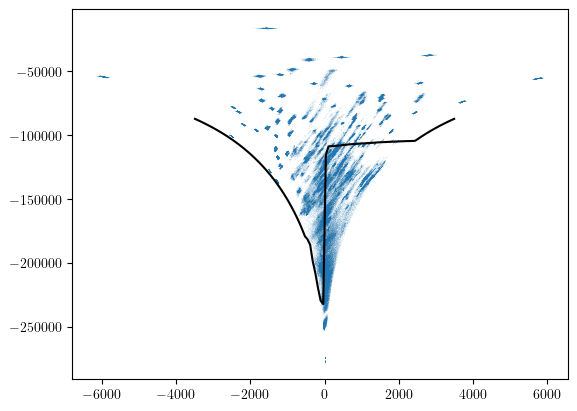

In [53]:
plt.scatter(Lz_flat[-1], E_flat[-1], s=0.1, alpha=0.1, lw=0)

plt.plot(J_phi_res_array, E_res_array[1], c='k')

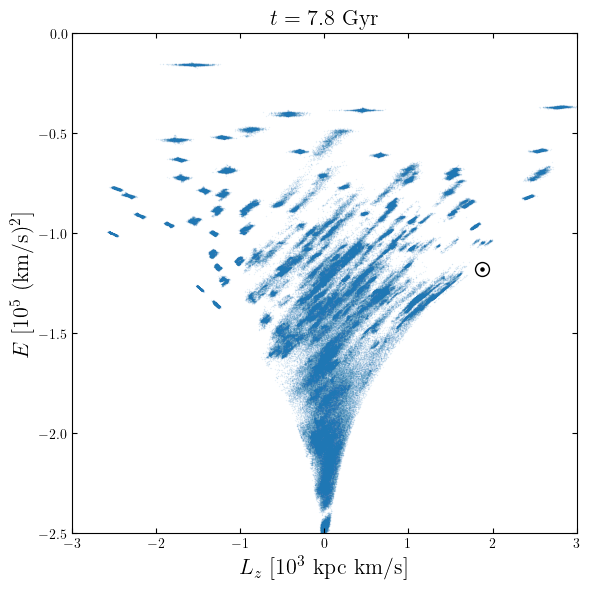

In [ ]:
'''Make animation of streams in E-Lz space'''

from matplotlib.animation import FuncAnimation

# Step 1: Prepare the data
# Generate random data points for the example
x = Lz_flat[0,:]/1e3
y = E_flat[0,:]/1e5

snap = 0

# Step 2: Create the figure and scatter plot
fig, ax = plt.subplots(figsize=(6,6))

scatter = ax.scatter(x, y, s=1, alpha=0.1, lw=0)

title = ax.set_title('$t=0$ Gyr', fontsize=16)

r0 = 8.178
vc0 = 229
Lz0 = r0 * vc0
E0 = 0.5 * vc0**2 + pot_axi.potential([r0, 0, 0])

ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='w', edgecolor='k', s=100, zorder=4)
ax.scatter(Lz0/1e3, E0/1e5, marker='o', c='k', s=5, zorder=4)

# Set the plot limits
Lz_max = 3
E_min = -2.5
E_max = 0
ax.set_xlim(-Lz_max, Lz_max)
ax.set_ylim(E_min, E_max)

# Step 3: Define the update function
# snap = 0
def update(frame):
    global x, y, i
    # Update the data points (here we are just adding a small random value)
    # snap += 1 
    x = Lz_flat[frame,:] / 1e3
    y = E_flat[frame,:] / 1e5
    # Update the scatter plot
    scatter.set_offsets(np.c_[x, y])
    title.set_text(f'$t={ts_Gyr[frame]:.1f}$ Gyr')
    
    return scatter,

ax.set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)
ax.set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)

ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')

# Step 4: Create the animation
# snap  = 0
ani = FuncAnimation(fig, update, frames=len(trajs_slow), interval=20, blit=True)

# Step 5: Display the animation
fig.set_tight_layout(True)

ani.save('GC_debris_bar.mp4', writer='ffmpeg', dpi=400)
plt.show()